In [135]:
## author: Virginia Ordoño Bernier
## date:January 2024

# Árbol de decisión con clasificación
El objetivo es clasificar el csv data2 que contiene datos sintéticos.

### Carga de datos

In [136]:
import pandas as pd

csv = './data/data2.csv'
data = pd.read_csv(csv)
df_data2 = pd.DataFrame(data)
print(df_data2.head())

   Feature_1  Feature_2  Label
0   0.496714   0.000000    0.0
1   0.647689   1.523030    0.0
2   0.000000   0.000000    0.0
3   1.579213   0.767435    0.0
4   0.000000   0.542560    0.0


In [137]:
df_data2['Label'] = df_data2['Label'].astype(int)
print(df_data2.head())

   Feature_1  Feature_2  Label
0   0.496714   0.000000      0
1   0.647689   1.523030      0
2   0.000000   0.000000      0
3   1.579213   0.767435      0
4   0.000000   0.542560      0


In [138]:
df_data2['Label'].unique()

array([0, 1])

### Análisis exploratorio para visualizar la distribución de las clases

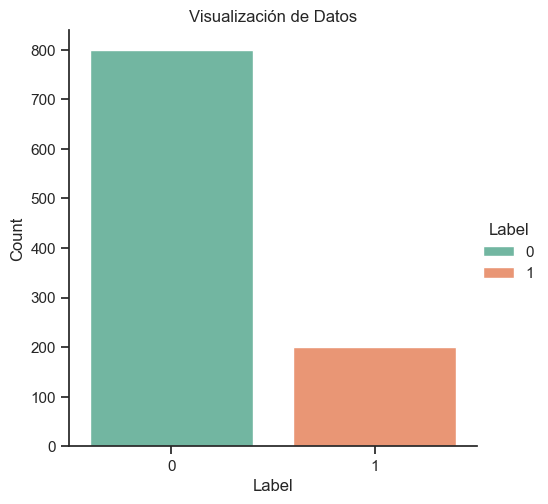

Instancias por clase
Label
0    800
1    200
dtype: int64


In [139]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(style='ticks') # line stlye
# kind='count' = amount of ocurrences of each class
sns.catplot(x='Label', data=df_data2, kind='count', hue='Label', palette='Set2')
plt.title("Visualización de Datos")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()
print('Instancias por clase')
print(df_data2.groupby('Label').size())

### Gráfico de Dispersión

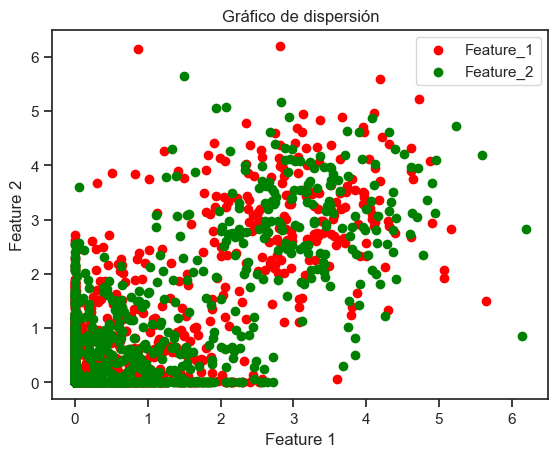

In [140]:
import pandas as pd
import matplotlib.pyplot as plt

# Crear un gráfico de dispersión usando plt.scatter
plt.scatter(df_data2['Feature_1'], df_data2['Feature_2'], c='red', label='Feature_1')
plt.scatter(df_data2['Feature_2'], df_data2['Feature_1'], c='green', label='Feature_2')

# Agregar etiquetas y título
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Gráfico de dispersión')

# Mostrar el gráfico
plt.legend()
plt.show()



### Preparación de los datos para el entrenamiento

In [141]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_data2, test_size=0.2, random_state=42)

# Reset index to maintain an order
train.reset_index(inplace = True)
test.reset_index(inplace = True)

print("Conjunto de entrenamiento:")
print(train.head())

print("\nConjunto de prueba:")
print(test.head())

Conjunto de entrenamiento:
   index  Feature_1  Feature_2  Label
0     29   0.331263   0.975545      0
1    535   0.000000   0.477041      0
2    695   0.459972   0.000000      0
3    557   0.150419   0.364961      0
4    836   2.608242   2.077590      1

Conjunto de prueba:
   index  Feature_1  Feature_2  Label
0    521   1.078681   0.000000      0
1    737   0.000000   0.648280      0
2    740   0.722381   0.000000      0
3    660   0.056650   0.529693      0
4    411   2.298898   0.000000      0


### Validación cruzada: optimización de parámetros

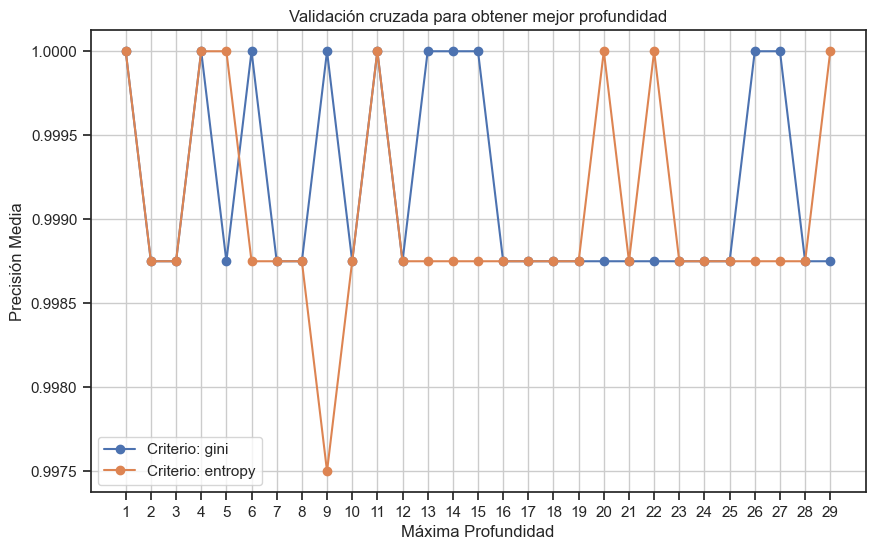


Gini
----------
Mejor profundidad: 1
Mayor Precisión: 1.0

Entropía
----------
Mejor profundidad: 1
Mayor Precisión: 1.0


In [142]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import matplotlib.pyplot as plt

cv = KFold(n_splits=5, shuffle=True)

max_accuracy_gini = 0
best_depth_gini = 0
max_accuracy_entropy = 0
best_depth_entropy = 0

total_scores_gini = []
total_scores_entropy = []

for i, criterion in enumerate(['gini', 'entropy']):
    fold_accuracies = []  # Initialize fold_accuracies inside the loop

    for max_depth in range(1, 30):

        # Accuracy in each iteration
        fold_accuracy = []
        tree = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth)

        for train_fold, test_fold in cv.split(train):

            # Division train and test
            f_train = train.loc[train_fold]
            f_test = train.loc[test_fold]

            # Fitting, predicting and evaluating the model
            tree.fit(X=f_train.drop(['Label'], axis=1), y=f_train['Label'])
            y_pred = tree.predict(X=f_test.drop(['Label'], axis=1))
            acc = accuracy_score(f_test['Label'], y_pred)

            # Saving precision
            fold_accuracy.append(acc)

        # Calculate and store the average accuracy for the current depth
        avg_accuracy = np.mean(fold_accuracy)
        fold_accuracies.append(avg_accuracy)

    total_scores_gini.append(fold_accuracies) if criterion == 'gini' else total_scores_entropy.append(fold_accuracies)

    # Check if the current depth results in a bigger accuracy
    max_acc = max(fold_accuracies)
    if criterion == 'gini' and max_acc > max_accuracy_gini:
        max_accuracy_gini = max_acc
        best_depth_gini = fold_accuracies.index(max_acc) + 1
    elif criterion == 'entropy' and max_acc > max_accuracy_entropy:
        max_accuracy_entropy = max_acc
        best_depth_entropy = fold_accuracies.index(max_acc) + 1

# Plot the results
plt.figure(figsize=(10, 6))
for i, scores in enumerate(total_scores_gini):
    plt.plot(range(1, 30), scores, marker='o', linestyle='-', label=f'Criterio: gini')

for i, scores in enumerate(total_scores_entropy):
    plt.plot(range(1, 30), scores, marker='o', linestyle='-', label=f'Criterio: entropy')

plt.title('Validación cruzada para obtener mejor profundidad')
plt.xlabel('Máxima Profundidad')
plt.ylabel('Precisión Media')
plt.xticks(range(1, 30))
plt.legend()
plt.grid(True)
plt.show()

# Gini
print('\nGini')
print('-'*10)
print(f"Mejor profundidad: {best_depth_gini}")
print(f"Mayor Precisión: {max_accuracy_gini}")

# Entropy
print('\nEntropía')
print('-'*10)
print(f"Mejor profundidad: {best_depth_entropy}")
print(f"Mayor Precisión: {max_accuracy_entropy}")


### Creación del modelo con los mejores hiperparámetros 

In [143]:
from sklearn.metrics import classification_report
X_train = train[['Feature_1', 'Feature_2']]
y_train = train['Label']
X_test = test[['Feature_1', 'Feature_2']]
y_test = test['Label']

model = DecisionTreeClassifier(max_depth = best_depth_entropy) 
model.fit(X_train, y_train) 
y_pred = model.predict(X_test)

print("\nInforme de Clasificación Entropía:")
print(classification_report(y_test, y_pred)) 


Informe de Clasificación Entropía:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       156
           1       0.93      0.86      0.89        44

    accuracy                           0.95       200
   macro avg       0.94      0.92      0.93       200
weighted avg       0.95      0.95      0.95       200



### Visualizacion del árbol de decisión

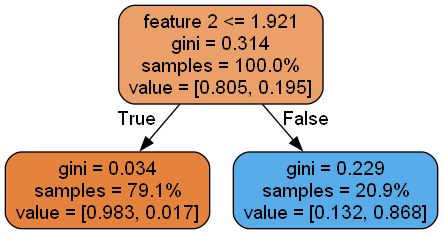

In [144]:
import pydot
from IPython.display import Image

from io import StringIO

from sklearn import tree

dot_data = StringIO()
tree.export_graphviz(model, out_file = dot_data, proportion = True, feature_names = ["feature 1", "feature 2"], rounded = True, filled = True)

graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())

### Importancia de las variables
La importancia de las variables se deriva del propio modelo, y se calcula observando cómo cada característica contribuye a reducir la impureza (o aumentar la pureza) de los nodos en el árbol de decisión durante el proceso de entrenamiento.

In [145]:
#X_train = train.drop('Label', axis=1)

# Gini criterio by default
classifier = tree.DecisionTreeClassifier(random_state=42)
classifier.fit(X_train, y_train)

# Get importance
importances = classifier.feature_importances_

# Create dataframe
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Exclude column 'index' if exists
if 'index' in feature_importance_df['Feature'].values:
    feature_importance_df = feature_importance_df[feature_importance_df['Feature'] != 'index']

# Order by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Informe de Importancia de las Variables:")
print(feature_importance_df)



Informe de Importancia de las Variables:
     Feature  Importance
1  Feature_2    0.801535
0  Feature_1    0.198465
